In [186]:
import numpy as np
import torch as th
import torch.nn as nn
from copy import deepcopy
import matplotlib.pyplot as plt
import random
from matplotlib import colors
from tqdm import tqdm
import cv2

### Environment
Environment for the robot to explore in the grid world and get according reward based on its actions. There are mainly three functions, `reset`, `step` and `render`.

In [187]:
class Environment:

    def __init__(self, grid_size, map, start, goal):
        self.grid_size = grid_size
        self.dim = 1.5
        self.map = map
        # Initialize position
        self.start_x = start[0]
        self.start_y = start[1]
        self.goal_x = goal[0]
        self.goal_y = goal[1]
        

    def _update_state(self, action):
        # Get current state coordinate and distance to the goal position
        state = self.state
        gy, gx, sy, sx = state
        old_d = abs(gx - sx) + abs(gy - sy)
        old_x = sx
        old_y = sy
        # Update current state position based on the action
        if action == 0:
            if sx > 0:
                sx -= 1
        if action == 1:
            if sx < self.grid_size-1:
                sx += 1
        if action == 2:
            if sy > 0:
                sy-= 1
        if action == 3:
            if sy < self.grid_size-1:
                sy += 1
        # if move to obstacles, stay at original position
        map_x = sx
        map_y = self.grid_size - sy - 1
        if self.map[map_y, map_x] == 0:
          sx = old_x
          sy = old_y
        # Based on the updated position, determine the reward
        new_d = abs(gx - sx) + abs(gy - sy)
        self.d = old_d-new_d
        self.time = self.time - 1
        return np.array([gy, gx, sy, sx])


    def _get_reward(self):
        # Based on the distance between updated position and goal position, select different reward 
        goal_y, goal_x, start_y, start_x = self.state
        if goal_x == start_x and goal_y == start_y: return 1
        if self.d == 1: return 1
        if self.d == 0: return -1
        if self.d == -1: return -1


    def _is_over(self):
        # If the robot reaches the goal position or time is gone, terminate current epsiode.
        goal_y, goal_x, start_y, start_x = self.state
        if self.time == 0: return True
        if goal_x == start_x and goal_y == start_y: return True
        return False


    def step(self, action):
        # Update current state based on action
        self.state = self._update_state(action)
        # Get according reward based on updated state 
        reward = self._get_reward()
        # Determine if current episode is terminated
        game_over = self._is_over()
        return self.state, reward, game_over


    def reset(self):
        # Initialize start and goal position and time limit
        time = self.grid_size * 3
        self.time = time
        self.d = 0
        self.state = np.array([self.goal_y, self.goal_x, self.start_y, self.start_x])
        return self.state


    def render(self, ds):
        # Based on current trajectory data, plot the robot optimal path in the map
        a = ds
        a_np = np.zeros((len(a),2))
        for i in range(len(a)):
            a_np[i] = a[i]['x'][-2:].numpy()
        a_np = a_np.astype(np.int32)
        map_x = a_np[:,1]
        map_y = self.grid_size - a_np[:,0] - 1
        test_image = np.zeros((self.map.shape[0], self.map.shape[1], 3))
        test_image[self.map == 1] = np.array([1,1,1])
        test_image[self.map == 0] = np.array([0,0,0])
        fig, ax = plt.subplots(figsize=(7, 7))
        ax.scatter(map_x, map_y, s=320, marker='*', color='gold', zorder=3)
        # Transform start and goal coordinate
        goal_y = self.grid_size - 1 - self.goal_y
        start_y = self.grid_size - 1 - self.start_y
        # Show the start and goal position
        ax.scatter(self.goal_x, goal_y, s=320, marker='*', color='red', zorder=3)
        ax.scatter(self.start_x, start_y, s=320, marker='*', color='blue', zorder=3)
        ax.imshow(test_image, interpolation='nearest')

### Q-Network
Q-Network consisting of three fully connected linear layers

In [188]:
class q_t(nn.Module):
    def __init__(s, xdim, udim, hdim=128):
        super().__init__()
        s.xdim, s.udim = xdim, udim
        s.m = nn.Sequential(
            nn.Linear(xdim, hdim),
            nn.ReLU(True),
            nn.Linear(hdim, hdim),
            nn.ReLU(True),
            nn.Linear(hdim, udim)
        )


    def forward(s, x):
        return s.m(x)


    def control(s, x, eps=0):
        # Get q values for all controls
        q = s.m(x)
        # eps-greedy strategy to choose control input
        # note that for eps=0 you should return the correct control u
        if th.rand(1).item() < eps:
            u = th.randint(0, s.udim, (1,))
        else:
            u = th.argmax(q)
        return u

### Utility Function
Helper function to generate the trajectories and update the Q-Network

In [189]:
def rollout(e, q, eps=0):
    '''
    Input:
    e: Environment
    q: Training Q-Network
    eps: Epsilon for training the Q-Network at different rate
    Return:
    traj: Trajectory of current Q-Network
    R: Reward of current trajectory
    '''
    traj = []
    # Reset environment and get initial state
    x = th.from_numpy(e.reset()).to(th.float) # Return initial observation (4,)
    R = 0
    while True:
        # Get action from policy (q network)
        u = q.control(x, eps=eps)
        # Execute action in the environment
        xp, r, d = e.step(u) # Returns observation(4,), reward, done and info.
        # Store current state summary into dictionary for return
        t = dict(x=x, xp=xp, r=r, u=u, d=d)
        traj.append(t)
        # Update current state
        x = th.from_numpy(xp).to(th.float)
        R += r
        # If done, terminate rollout
        if d:
            break
    
    return traj, R


def loss(q, q_NNdelay, ds):
    '''
    Input:
    q: Training Q-Network
    q_NNdelay: Delayed Q-Network to aid training of q
    ds: Data trajectories
    Return:
    f: Mean square error of current Q-Network
    '''

    # Intialize necessary parameters 
    discount = 0.9
    # First, get mini-batch sampled current state, next state, current reward and current actions.
    x_s, xp_s, r_s, u_s = mini_batch_sample(ds)
    # Then, calculate the target term
    u_prime = th.argmax(q(xp_s), 1).view(-1,1)
    q_delay = q_NNdelay(xp_s)
    q_delay_u = q_delay.gather(1,u_prime)
    target = r_s + discount * q_delay_u
    # Calculate loss
    q_curr = q(x_s)
    # q_curr = q_curr[np.arange(q_curr.shape[0]), u_s].view(-1,1)
    q_curr = q_curr.gather(1,u_s)
    # Finally, calculate the loss
    f = (q_curr - target)**2
    f = f.mean()
    return f


def mini_batch_sample(ds, batch_size=20):
    '''
    Input: 
    ds (N,): List containing N trajectories each with n timestep data
    batch_size: Number of data in one batch
    Return:
    x_s (batch_size, 4): Current state x_t
    xp_s (batch_size, 4): Next state x_(t+1)
    r_s (batch_size, 1): Current reward at x_t
    u_s (batch_size,): Current actions u_t at state x_t
    '''
    # Initialize container variable and index
    x_s = []
    xp_s = []
    r_s = []
    u_s = []
    i = 0
    traj_rand = np.random.permutation(len(ds))
    # Iterate through all random selected trajectories until enough batches are selected
    while i < batch_size:
        traj_idx = traj_rand[i] # Random selected trajectory index
        time_rand_idx = np.random.randint(0, len(ds[traj_idx])) # Random time step index of selected trajectory
        curr = ds[traj_idx][time_rand_idx]
        x_s.append(curr['x'])
        xp_s.append(curr['xp'])
        r_s.append(curr['r'])
        u_s.append(curr['u'])
        i += 1
    # Reshape array for return
    x_s = th.from_numpy(np.stack(x_s)).to(th.float)
    xp_s = th.from_numpy(np.stack(xp_s)).to(th.float)
    r_s = th.from_numpy(np.array(r_s).reshape(-1,1))
    # u_s = th.from_numpy(np.array(u_s)).view(-1,1)
    u_s = th.tensor(u_s).view(-1,1)
    
    return x_s, xp_s, r_s, u_s

### Generate different test maps
1. Random map

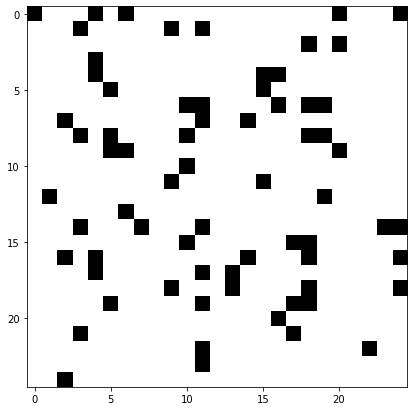

In [190]:
# Given the world size, generate the random map
world_size = 25
np.random.seed(32)
map = np.ones((world_size,world_size))
x_random = np.random.randint(0,world_size, 70)
y_random = np.random.randint(0,world_size, 70)
map[y_random,x_random] = 0
map[9,0] = 1
map[0,9] = 1
# Plot the random generated map
plt.figure(figsize=(7,7))
plt.imshow(map, cmap='gray')

2. Levine 4th floor simplified grid map

Text(0.5, 1.0, 'DQN Map')

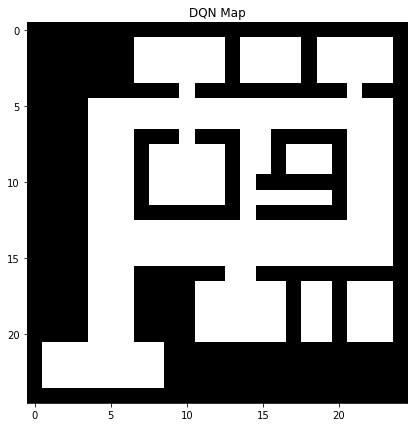

In [191]:
grid_ = cv2.imread('aa.png',0)
row_step, col_step = np.ceil(np.array(grid_.shape)/25).astype(int)

world_size = 25
DQN_map = np.zeros((25,25))
for row in range(25):
    for col in range(25):
        row_idx = int(row_step/2 + row * row_step)
        col_idx = int(col_step/2 + col * col_step)
        if grid_[row_idx, col_idx] == 255:
            DQN_map[row, col] = 1

plt.figure(figsize=(7,7))
plt.imshow(DQN_map,cmap='gray')
plt.title('DQN Map')

### Main
Train the Q-Network for 10 episodes and keep record of the reward change

100%|██████████| 1000/1000 [00:39<00:00, 25.13it/s]


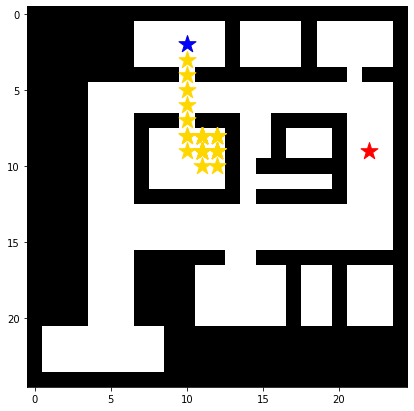

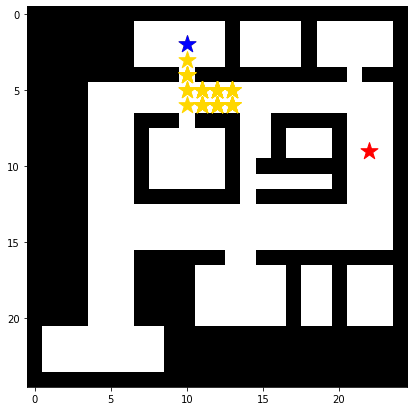

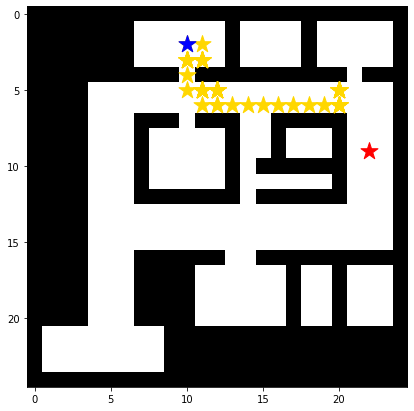

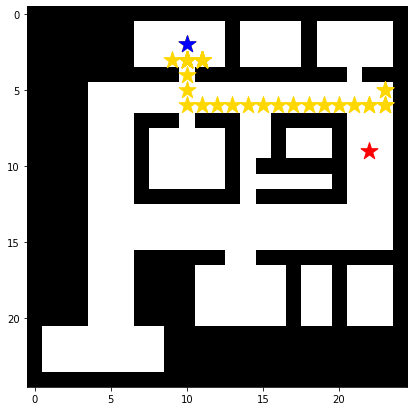

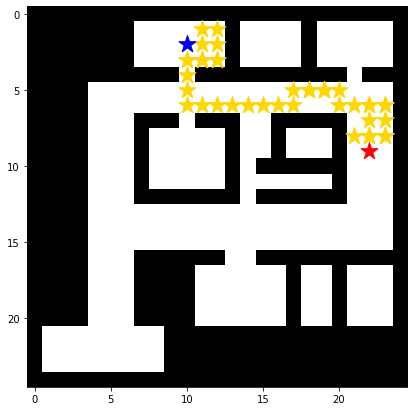

In [192]:
for mainLoop in range(1):
    # Create environment
    start = [10,22]
    goal = [22,15]
    e = Environment(world_size, DQN_map, start, goal)
    xdim, udim = 4, 4

    # Create q network
    q = q_t(xdim, udim)
    optim = th.optim.Adam(q.parameters(), lr=1e-2, weight_decay=1e-4)
    qNNdelay = deepcopy(q)

    # Run the Q-learning 5 times and keep record of the average return of each episode
    rew_total = []
    rew_total2 = []
    for epi in range(5):
        # Dataset of trajectories
        ds = []
        # Keep track of all return in current episode
        rew_epi = []
        # Collect few random trajectories with eps=1
        for i in range(1000):
            traj, _ = rollout(e, q, eps=1)
            ds.append(traj)
        # Train q-network for another 1000 trajectories
        for i in tqdm(range(1000)):
            eps = 0.01 + (1 - 0.01)*np.exp(-0.005*i)
            q.train()
            t, R = rollout(e, q, eps=eps)
            ds.append(t)
            rew_epi.append(R)
            rew_total2.append(R)

            # Perform weights updates on the q network
            # need to call zero grad on q function to clear the gradient buffer
            q.zero_grad()
            optim.zero_grad()
            f = loss(q, qNNdelay, ds)
            f.backward()
            optim.step()

            # Exponential averaging for the target
            alpha = 0.05
            old_param = qNNdelay.state_dict()
            actual_param = q.state_dict()
            for param in old_param:
                old_param[param] = (1 - alpha) * old_param[param] + alpha * actual_param[param]
            qNNdelay.load_state_dict(old_param)

        # Render the best trajectory with highest reward in current episode
        idx = np.argmax(rew_epi)
        best_traj = 1000 + idx
        e.render(ds[best_traj])
        
        # After running 1000 weight update in current episode, get the current average episode reward
        rew_total.append(sum(rew_epi)/len(rew_epi))

### Result
Plot the reward change across entire trajectory of DQN as evaluation metrics

Text(0, 0.5, 'Reward')

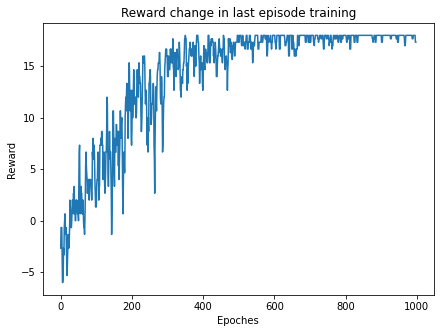

In [8]:
# Extract the last episode's reward training curve for plot
i = 9
episode_rewards = rew_total2[i*1000:(i+1)*1000]
smoothing = 3
episode_ma = np.convolve(episode_rewards, 
                         np.ones((smoothing,))/smoothing, mode='valid')
plt.figure(figsize=(7,5))
plt.plot(episode_ma)
plt.title('Reward change in last episode training')
plt.xlabel('Epoches')
plt.ylabel('Reward')